## Tensor RNN for long term forecasting demo 
- seq2seq architecture with tensor RNN cell
- variable length of forecasting horizon
- flexible temporal high order structure

### step 1: Flags for training configuration

In [1]:
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
from model_seq2seq import *
from trnn import *
import numpy 
from train_config import *


flags = tf.flags
flags.DEFINE_string("model", "TLSTM",
          "Model used for learning.")
flags.DEFINE_string("data_path", "./dat_train.npy",
          "Data input directory.")
flags.DEFINE_string("save_path", "./log/tlstm/",
          "Model output directory.")
flags.DEFINE_bool("use_sched_samp", False,
                  "Use scheduled sampling in training")
flags.DEFINE_integer("inp_steps", 12, "burn in steps")
flags.DEFINE_integer("out_steps", None, "test steps")
flags.DEFINE_integer("hidden_size", 8, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
flags.DEFINE_float("decay_rate", 0.8, "learning rate")
flags.DEFINE_integer("rank", 1, "rank for tt decomposition")

FLAGS = flags.FLAGS
print('Flags configuration loaded ...')

/Users/william/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Flags configuration loaded ...


### step 2: Read flags and data into memory

In [2]:
# FLAGS = FLAGS.flag_values_dict()
print(FLAGS)


/Users/william/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:
  --data_path: Data input directory.
    (default: './dat_train.npy')
  --decay_rate: learning rate
    (default: '0.8')
    (a number)
  --hidden_size: hidden layer size
    (default: '8')
    (an integer)
  --inp_steps: burn in steps
    (default: '12')
    (an integer)
  --learning_rate: learning rate
    (default: '0.001')
    (a number)
  --model: Model used for learning.
    (default: 'TLSTM')
  --out_steps: test steps
    (an integer)
  --rank: rank for tt decomposition
    (default: '1')
    (an integer)
  --save_path: Model output directory.
    (default: './log/tlstm/')
  --[no]use_sched_samp: Use scheduled sampling in training
    (default: 'false')

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag 

In [3]:
'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series.
'''

# Training Parameters
config = TrainConfig()
config.hidden_size = FLAGS.flag_values_dict()["hidden_size"]
config.learning_rate = FLAGS.flag_values_dict()["learning_rate"]
config.decay_rate = FLAGS.flag_values_dict()["decay_rate"]
config.rank_vals = [FLAGS.flag_values_dict()["rank"]]

# Scheduled sampling [optional]
if FLAGS.flag_values_dict()['use_sched_samp']:
    config.sample_prob = tf.get_variable("sample_prob", shape=(), initializer=tf.zeros_initializer())
sampling_burn_in = 400

# Training Parameters
training_steps = config.training_steps
batch_size = config.batch_size
display_step = 500
inp_steps = config.inp_steps
out_steps = FLAGS.flag_values_dict()['out_steps']


# Read Dataset
dataset, stats = read_data_sets(FLAGS.flag_values_dict()['data_path'], True, inp_steps, out_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 3)
num_steps = stats['num_steps']

if out_steps is None:
    # Forecast for the rest if horizon is not set
    out_steps = num_steps - inp_steps

# Print training config
print('-'*100)
print('|input steps|', inp_steps, '|out steps|', out_steps ,'|', 'hidden size|',config.hidden_size, '|learning rate|',
     config.learning_rate, '|rank val|', config.rank_vals)
print('-'*100)

loading time series ...
input type  <class 'numpy.ndarray'> (3502, 165, 1)
normalize to (0-1)
----------------------------------------------------------------------------------------------------
|input steps| 12 |out steps| 153 | hidden size| 8 |learning rate| 0.001 |rank val| [1]
----------------------------------------------------------------------------------------------------


### visualize time series samples
load the raw data into the notebook to visualize

loading time series ...


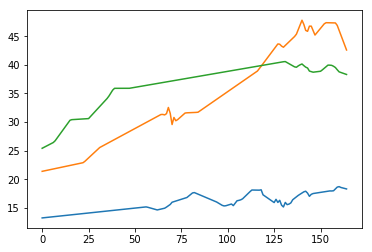

In [4]:
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline


print("loading time series ...")
data = np.load(FLAGS.flag_values_dict()['data_path'])
# Expand the dimension if univariate time series
if (np.ndim(data)==1):
        data = np.expand_dims(data, axis=1)
plt.plot(data[0:3,:,0].T)

### Step 3: Build neural network models
Building seq2seq model for training/validation/testing,
validation and testing models are shared,
scheduled sampling is by default off 

In [5]:
# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

Model = globals()[FLAGS.flag_values_dict()["model"]]
with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, Y, True,  config)
with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True):
        test_pred = Model(X, Y, False,  config)


# Define loss and optimizer
train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Z)))

# Exponential learning rate decay 
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = config.learning_rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           2000, config.decay_rate, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_op = optimizer.minimize(train_loss,global_step=global_step)

# Scheduled sampling params
eps_min = 0.1 # minimal prob

# Write summary
train_summary = tf.summary.scalar('train_loss', train_loss)
valid_summary = tf.summary.scalar('valid_loss', test_loss)
lr_summary = tf.summary.scalar('learning_rate', learning_rate)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Saver for the model and loss
saver = tf.train.Saver()
hist_loss =[]

Training -->
          Create Encoder ...
          Create Decoder ...
Testing -->
          Create Encoder ...
          Create Decoder ...


### Training loop
This may take a while, training loss is displayed at every 500 steps, 
use GPU can speed up training

In [6]:
# Start training
with tf.Session() as sess:
    # Merge all the summaries and write them out to /log/tlstm (by default)
    merged = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(FLAGS.flag_values_dict()["save_path"],sess.graph)

    # Run the initializer
    sess.run(init)    
    
    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, Z:batch_z})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            summary, loss = sess.run([merged,train_loss], feed_dict={X: batch_x,Y: batch_y, Z:batch_z})
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            summary_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            summary_writer.add_summary(summary, step)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )
            
            # Calculate validation
            valid_enc_inps = dataset.validation.enc_inps.reshape((-1, inp_steps, num_input))
            valid_dec_inps = dataset.validation.dec_inps.reshape((-1, out_steps, num_input))
            valid_dec_outs = dataset.validation.dec_outs.reshape((-1, out_steps, num_input))
            va_sum, va_loss = sess.run([valid_summary,test_loss],
                                       feed_dict={X: valid_enc_inps, Y: valid_dec_inps, Z: valid_dec_outs})
            summary_writer.add_summary(va_sum, step) 
            print("Validation Loss:", va_loss)
            
            # Overfitting
            hist_loss.append(va_loss)
            if len(hist_loss)>20 and va_loss > np.mean(hist_loss):
                print("Early stopping: step ", step)
                break
          
            #Update sampling prob
            if FLAGS.flag_values_dict()["use_sched_samp"] and step > sampling_burn_in:
                sample_prob = max(eps_min, 1.0-step/(2*training_steps))
                sess.run(tf.assign(config.sample_prob, sample_prob))
                print('Sampling prob:', sample_prob)

    print("Optimization Finished!")

    # Calculate accuracy for test datasets
    test_enc_inps = dataset.test.enc_inps.reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps.reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs.reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Z,
        "pred":test_pred,
        "loss":test_loss
    }
    test_vals = sess.run(fetches, feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs})
    print("Testing Loss:", test_vals["loss"])

    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.flag_values_dict()["save_path"])
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\t'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) +'\t'+ 'valid_error:' + str(va_loss) + '\t'+ 'test_error:'+ str(test_vals["loss"]) +'\n')

Step 1, Minibatch Loss= 0.2617
Validation Loss: 0.25263816
Step 500, Minibatch Loss= 0.1657
Validation Loss: 0.18096396
Step 1000, Minibatch Loss= 0.1148
Validation Loss: 0.15748346
Step 1500, Minibatch Loss= 0.0824
Validation Loss: 0.1636688
Step 2000, Minibatch Loss= 0.0947
Validation Loss: 0.1415943
Step 2500, Minibatch Loss= 0.1127
Validation Loss: 0.1378033
Step 3000, Minibatch Loss= 0.1096
Validation Loss: 0.13045494
Step 3500, Minibatch Loss= 0.0885
Validation Loss: 0.12709256
Step 4000, Minibatch Loss= 0.1039
Validation Loss: 0.13934137
Step 4500, Minibatch Loss= 0.0984
Validation Loss: 0.119099244
Step 5000, Minibatch Loss= 0.1015
Validation Loss: 0.122555226
Optimization Finished!
Testing Loss: 0.13292904
Model saved in file: ./log/tlstm/


### Visualize predictions

In [58]:
y_true = test_vals["true"]
y_pred = test_vals["pred"]
for i in range(y_true.shape[0]):
    plt.plot(y_true[i,:,0].T,':')
    plt.plot(y_pred[i,:,0].T,'-')
    plt.savefig("./figs/figure%s.png"%i)
    plt.close()
    print(i, " is saved")